In [2]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

### Training

Here, our 1000 synthetic data will follow the trigonometric sin function, applied to 0.01 times the time step. To make the problem a little more interesting, we corrupt each sample with additive noise. From this sequence we extract training examples, each consisting of features and a label.

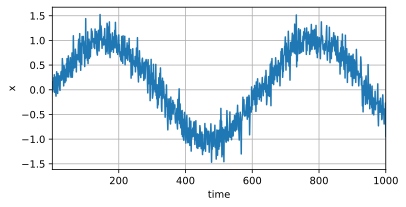

In [3]:
class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
        self.save_hyperparameters()
        self.time = torch.arange(1, T + 1, dtype=torch.float32)
        # x = sin(t) + \epsilon * 0.2 where \epsilon is drawn from standard distribution
        self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2
    
    def get_dataloader(self, train):
        features = [self.x[i : self.T-self.tau+i] for i in range(self.tau)]
        self.features = torch.stack(features, 1)
        self.labels = self.x[self.tau:].reshape((-1, 1))
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.features, self.labels], train, i)

data = Data()
d2l.plot(data.time, data.x, 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

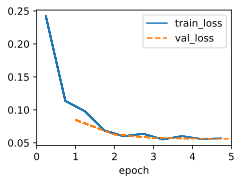

In [6]:
model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)

### Prediction

Single-step predictions

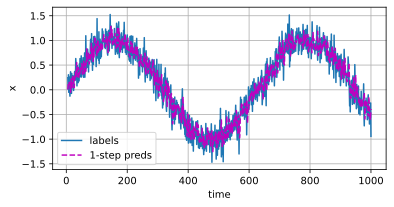

In [8]:
onestep_preds = model(data.features).detach().numpy()
d2l.plot(data.time[data.tau:], [data.labels, onestep_preds], 'time', 'x',
         legend=['labels', '1-step preds'], figsize=(6,3))

Multi-step predictions, i.e. we autoregress continuously on model predictions

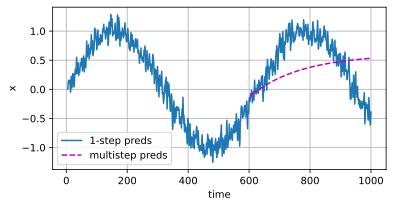

In [14]:
multistep_preds = torch.zeros(data.T)
multistep_preds[:] = data.x
# Starting at x_600 + tau and basing our predictions on a tau'th order markov model
for i in range(data.num_train + data.tau, data.T):
    multistep_preds[i] = model(
        multistep_preds[i - data.tau:i].reshape((1, -1)))
multistep_preds = multistep_preds.detach().numpy()

d2l.plot([data.time[data.tau:], data.time[data.num_train+data.tau:]],
         [onestep_preds, multistep_preds[data.num_train+data.tau:]], 'time',
         'x', legend=['1-step preds', 'multistep preds'], figsize=(6, 3))

k-step predictions, i.e. we predict k-steps into the future

In [16]:
def k_step_pred(k):
    features = []
    for i in range(data.tau):
        features.append(data.x[i : i+data.T-data.tau-k+1])
     # The (i+tau)-th element stores the (i+1)-step-ahead predictions
    for i in range(k):
        preds = model(torch.stack(features[i : i+data.tau], 1))
        features.append(preds.reshape(-1))
    return features[data.tau:]

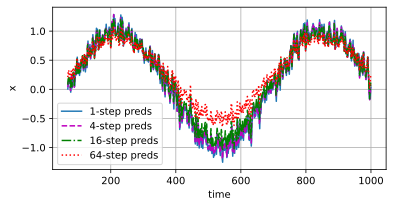

In [17]:
steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])
d2l.plot(data.time[data.tau+steps[-1]-1:],
         [preds[k - 1].detach().numpy() for k in steps], 'time', 'x',
         legend=[f'{k}-step preds' for k in steps], figsize=(6, 3))

This clearly illustrates how the quality of the prediction changes as we try to predict further into the future. While the 4-step-ahead predictions still look good, anything beyond that is almost useless.

###  Exercises

1. Improve the model in the experiment of this section.

- Incorporate more than the past 4 observations? How many do you really need?

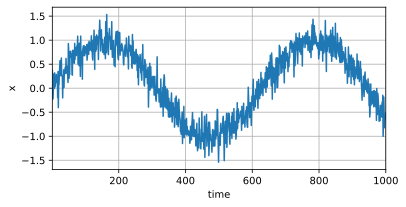

In [18]:
# Let's try tau = 10
data = Data(tau=10)
d2l.plot(data.time, data.x, 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

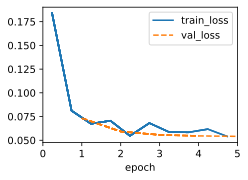

In [19]:
model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)

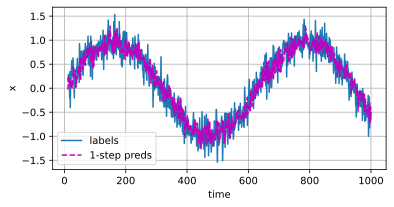

In [20]:
onestep_preds = model(data.features).detach().numpy()
d2l.plot(data.time[data.tau:], [data.labels, onestep_preds], 'time', 'x',
         legend=['labels', '1-step preds'], figsize=(6,3))

Not much accuracy was gained by observing past 10 data points. 4 seems to do the trick just fine

- How many past observations would you need if there was no noise? Hint: you can write $\sin$ and $\cos$ as a differential equation.

- Change the neural network architecture and evaluate the performance. You may train the new model with more epochs. What do you observe?

model = d2l.MLP